<h1 style="color:#b01e3a;">Diabetes Risk Prediction</h2>

Prediction of diabetis risk based on the healthcare indicators. Machine learning project.

__Table of Contents__

1. [About the project](#about)
2. [Load data](https://github.com/nadia-paz/cdc_diabetes/blob/main/notebook.ipynb#loaddata)
3. [Exploratory Data Analysis](#eda)
4. Creating and Tuning ML models
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGBoost
5. Training the Final model

<a name="about"></a> 
### About the project

> The project involves working with BRFSS data from CDC. The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that collects data about US residents' health-related risk behaviors, chronic health conditions, and use of preventive services. If you want to learn more about the data and its source, please refer to the `Readme` file of the project. <br>

- The main objective of the project is to develop a __machine-learning model__ that can *predict the risk of developing diabetes based on health indicators*. 
- As a secondary objective, this project aims to make a positive impact on people's lives by using the power of machine learning to predict the risks of developing diabetes. By analyzing health indicators and risk behaviors, I hope to create a model that can help individuals take proactive steps toward their health and well-being.


In [17]:
# imports
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import stats 
from sklearn.metrics import mutual_info_score

# load data preparation module
import src.data_prep as dp
import src.explore as ex

pd.set_option('display.float_format', lambda x: '%.3f' % x)

<a class="anchor" id="loaddata"></a>
### Load data

The data preparation code is located in the `data_prep.py` file in the `src` directory. It loads data, drops duplicates, converts data types, and splits data into `train`, `validation`, and `test` sets.

In [2]:
# load the data
df = dp.acquire()
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


Upon initial inspection, the data appeared to mostly consist of digital values and was prepared for machine learning. However, it was not user-friendly for data exploration. Based on the data dictionary provided in the `Readme` file I replaced numerical values in categorical columns with human-readable information. This makes the process of data exploration easier. Those changes only impact `df_explore` data frame, which excludes any data from the `test` data set, and leaves the original data untouched as well.

<a name="eda"></a> 
### Exploratory Data Analysis

In [6]:
from importlib import reload

In [7]:
reload(dp)

<module 'src.data_prep' from '/Users/nadina/Documents/Zoomcapm/projects/cdc_diabetes/src/data_prep.py'>

In [11]:
df_explore = dp.split_data(df, explore=True)
df_explore.head(3).T

,0,1,2
HighBP,Normal Blood Pressure,Normal Blood Pressure,Normal Blood Pressure
HighChol,High Cholesterol,Normal Cholesterol,High Cholesterol
CholCheck,Had Cholesterol Check,Had Cholesterol Check,Had Cholesterol Check
BMI,42,27,35
Smoker,Not a Smoker,Not a Smoker,Smoker
Stroke,Didn't Have a Stroke,Didn't Have a Stroke,Didn't Have a Stroke
HeartDiseaseorAttack,No Heart Disease,No Heart Disease,No Heart Disease
PhysActivity,No Physical Activity - 30 days,No Physical Activity - 30 days,Active in the past 30 days
Fruits,Eats at least 1 friut a day,Eats at least 1 friut a day,Eats at least 1 friut a day
Veggies,Eats at least 1 vegetable a day,Eats at least 1 vegetable a day,Eats at least 1 vegetable a day


In [10]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183579 entries, 0 to 183578
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HighBP                183579 non-null  object  
 1   HighChol              183579 non-null  object  
 2   CholCheck             183579 non-null  object  
 3   BMI                   183579 non-null  int64   
 4   Smoker                183579 non-null  object  
 5   Stroke                183579 non-null  object  
 6   HeartDiseaseorAttack  183579 non-null  object  
 7   PhysActivity          183579 non-null  object  
 8   Fruits                183579 non-null  object  
 9   Veggies               183579 non-null  object  
 10  HvyAlcoholConsump     183579 non-null  object  
 11  AnyHealthcare         183579 non-null  object  
 12  NoDocbcCost           183579 non-null  object  
 13  GenHlth               183579 non-null  category
 14  MentHlth              183579 non-nul

Let's have a look on our target variable - Diabetes. What percentage of people represented in our data have diabetes?

In [15]:
df_explore.Diabetes.value_counts(normalize=True)

Diabetes
No Diabetes   0.847
Diabetes      0.153
Name: proportion, dtype: float64

- 84.7% of respondents don't have Diabetes
- 15.3% of respondets have Diabetes condition.

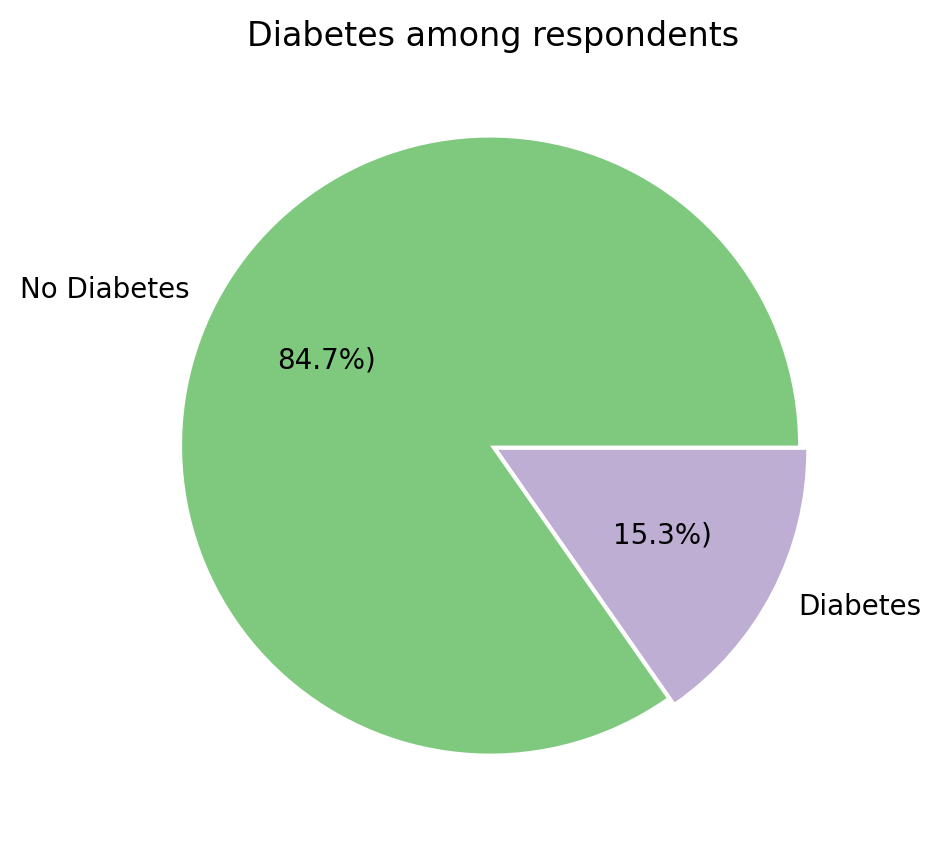

In [18]:
# visualize 
ex.diabetes_piechart(df_explore, 'Diabetes')

Next step is to explore if BMI (body mass index) differs between healthy people and people with diabetes. As we know from the theory, overweight people tend to have higher chances of getting type II diabetes. We need to check if our data follows this trend. Normal BMI range is between 18.5 and 24.9. Everything below 18.5 is underweight, everything above 24.9 is overweight. First, let's make some data splits, to help us explore.

In [19]:
# create 2 data frames for ppl with diabetis and without
healthy = df_explore.query('Diabetes_binary == 0')
diabetes = df_explore.query('Diabetes_binary == 1')

In [22]:
# check if the split is correct
healthy.Diabetes.unique(), diabetes.Diabetes.unique()

(array(['No Diabetes'], dtype=object), array(['Diabetes'], dtype=object))

In [23]:
# min, average and max BMI for healthy ppl
healthy.BMI.min(), healthy.BMI.mean(), healthy.BMI.max()

(12, 28.092849334447944, 98)

In [24]:
# min, average and max BMI for ppl with diabetes
diabetes.BMI.min(), diabetes.BMI.mean(), diabetes.BMI.max()

(13, 32.00181695108483, 98)

Although the min and max are almost the same, the average BMI is almost 4 points higher for people with diabetes.

In [26]:
reload(ex)

<module 'src.explore' from '/Users/nadina/Documents/Zoomcapm/projects/cdc_diabetes/src/explore.py'>

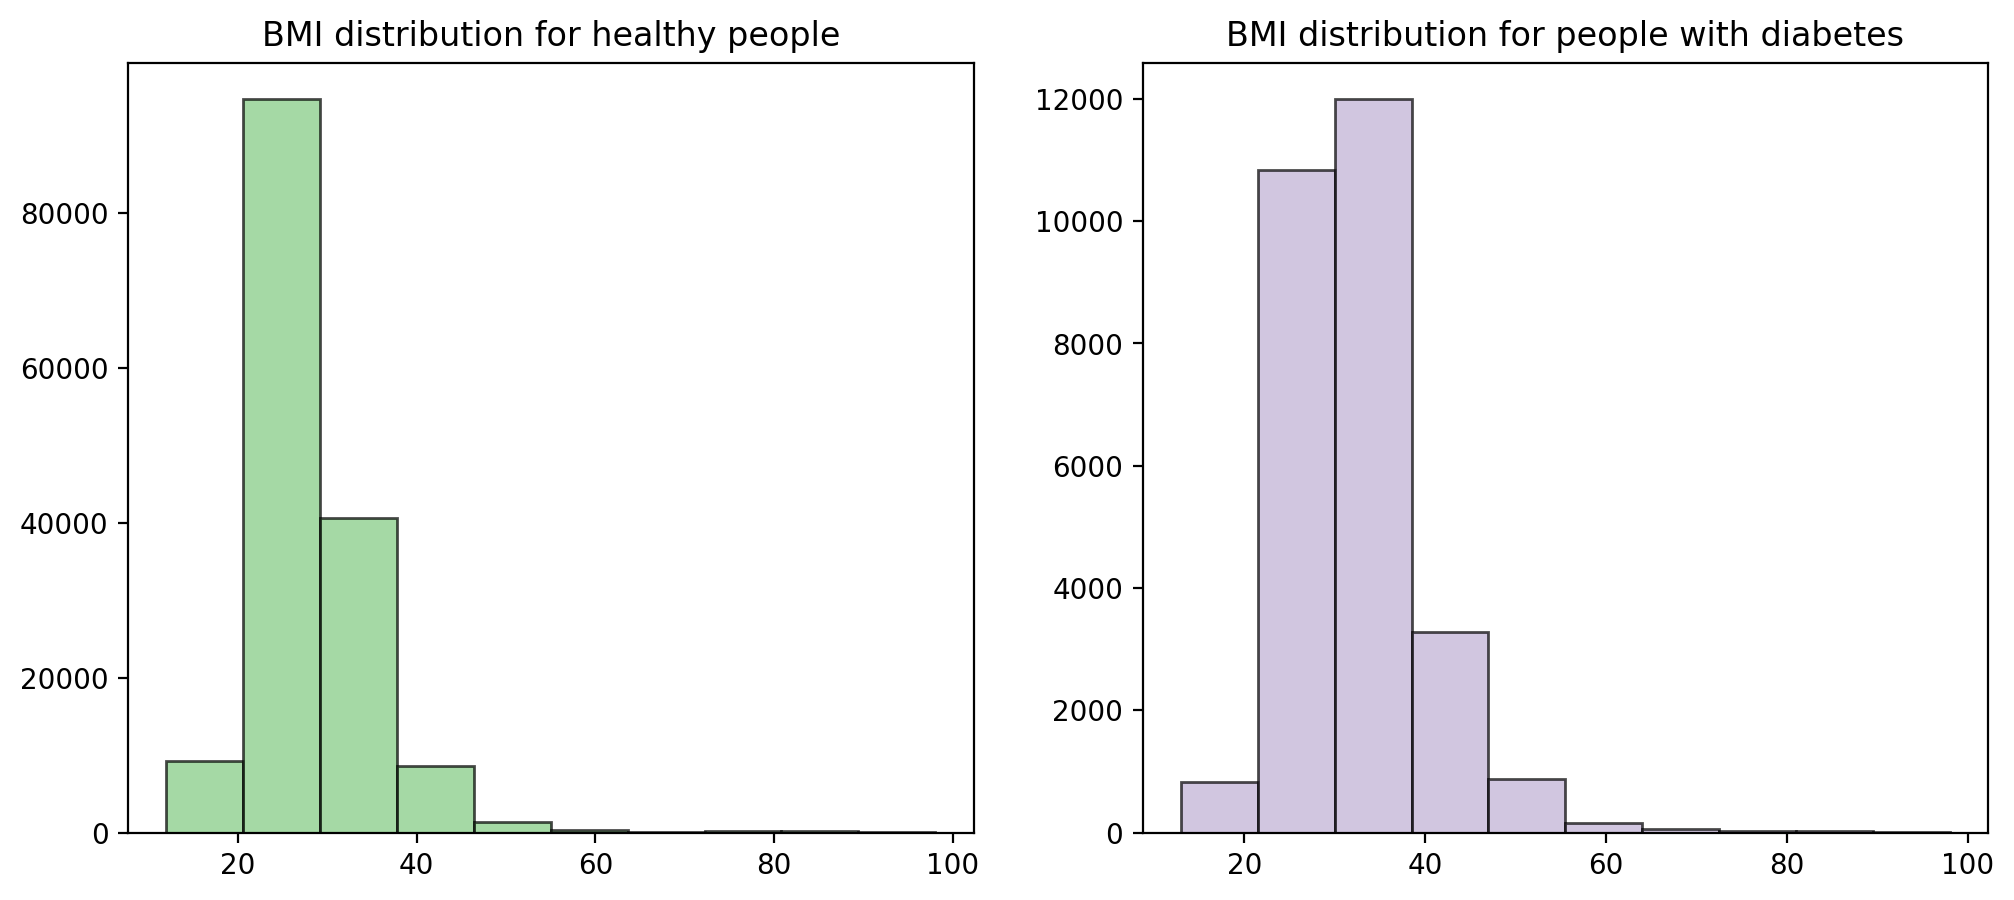

In [27]:
# visualize BMI distribution among people with and without diabetes
ex.bmi_distribution(healthy, diabetes)

The visual confirm that people with diabetes tend to have higher BMIs.

In [28]:
under = df_explore.query('BMI <= 18')
normal = df_explore.query('BMI > 18 and BMI < 25')
over = df_explore.query('BMI >= 25')

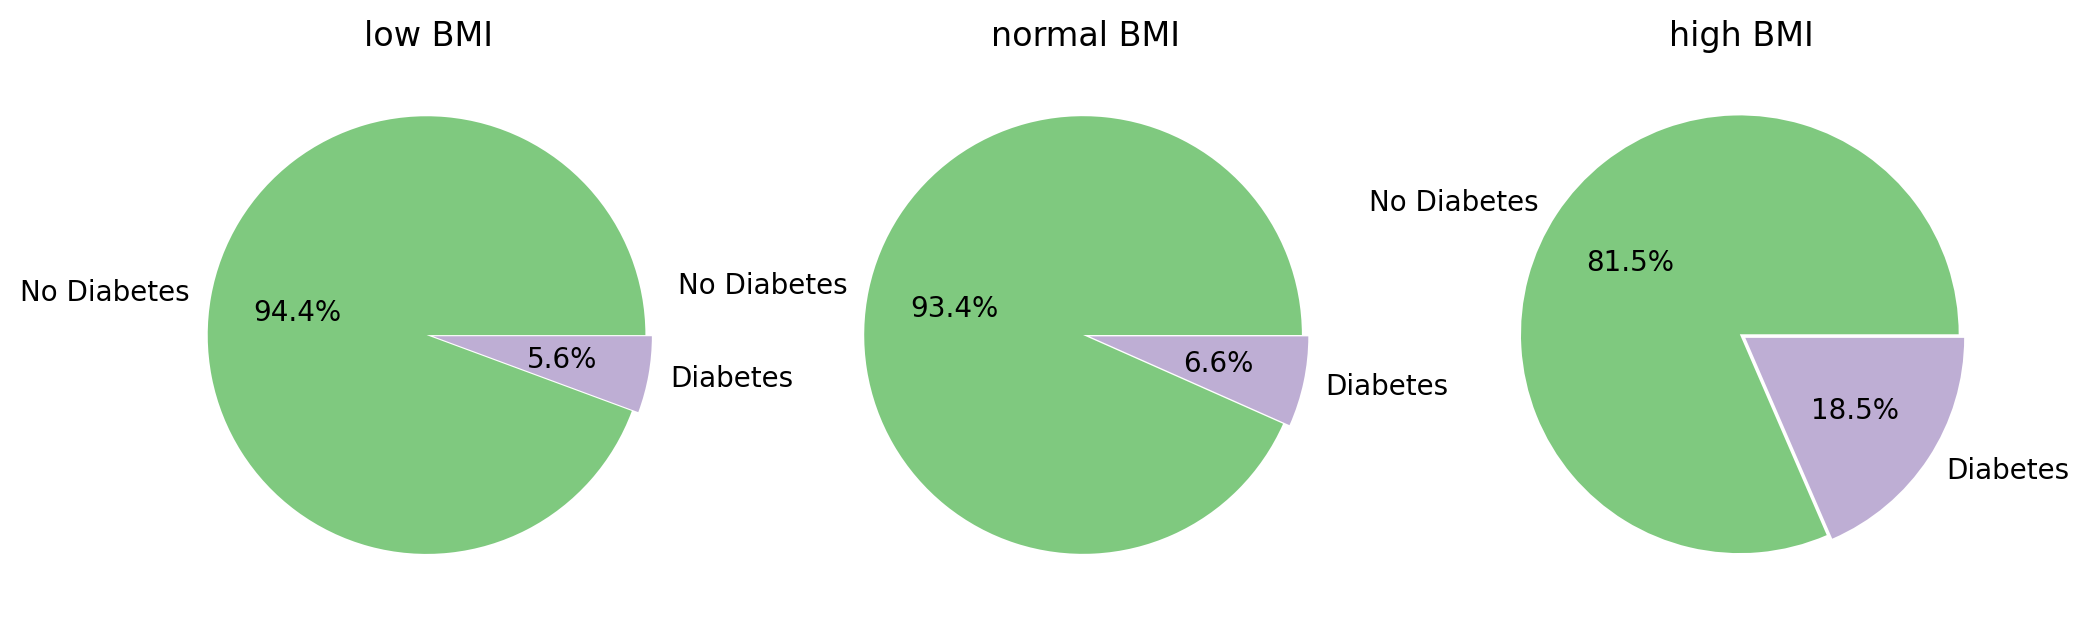

In [69]:
ex.bmi_piechart(under, normal, over)